</center><img src="letsgodeep_icon.png"></center>

#                                          Binary Image Segmentation

## Import Files of PyTroch


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

## UNET architecture

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
         
        )

    def forward(self, x):
        return self.conv(x)

## Process flow of UNET

In [3]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [7]:
#testing the class architecture
x= torch.randn((3,1,160,160))
model = UNET(in_channels=1,out_channels=1)
preds  = model(x)
print(preds.shape)
print(x.shape)

#from the result it is clear that the input channel and the output channel size is same

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


## Data loader 

In [8]:
#dataset for dataloading part
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np


In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

    


# Utils 

In [9]:
import torch
import torchvision
# from dataset import CarvanaDataset
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(loader, model, folder="sample_predictions/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

# train the model

In [9]:
#imports and the basic parameters
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim

LEARNING_RATE = 1e-4
DEVICE = "cpu" #"cuda" if torch.cuda.is_available() else 
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "data/train_images"
TRAIN_MASK_DIR = "data/train_masks"
VAL_IMG_DIR = "data/val_images"
VAL_MASK_DIR = "data/val_masks"


def train_fn(loader,model,optimizer,loss_fn,scaler):
    loop = tqdm(loader)
    
    for batch_idx,(data,targets) in enumerate(loop):
        data = data.to(device = DEVICE)
        targets  = targets.float().unsqueeze(1).to(device = DEVICE)
        
        
        #forward
        
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions,targets)
               
        #backwards
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        #update tqdm loop
        loop.set_postfix(loop=loss.item())
        
        
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )
    model = UNET(in_channels =3,out_channels=1).to(DEVICE)#OUT CHANNEL =3 FOR  3 DIFFERENT COLOR DATA
    loss_fn  = nn.BCEWithLogitsLoss()  #CROSS ENTROPY LOSS
    
    optimizer  = optim.Adam(model.parameters(),lr = LEARNING_RATE)
    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        #save the model
        checkpoint = {
            "state_dict":model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        
        save_checkpoint(checkpoint)
        
        #check the accuracy
        check_accuracy(val_loader,model,device = DEVICE)
        
        #print some examples to a floader
        save_predictions_as_imgs(
            val_loader,model,folder="sample_predictions/",device=DEVICE
        )
        
if __name__ == "__main__":
    main()

/home/nkumar/.local/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
  0%|                                                                                                                         | 0/315 [00:00<?, ?it/s]/home/nkumar/.local/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [1:28:48<00:00, 16.92s/it, loop=0.122]


=> Saving checkpoint
Got 1822865/1843200 with acc 98.90
Dice score: 0.9763490557670593


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [1:35:23<00:00, 18.17s/it, loop=0.0693]


=> Saving checkpoint
Got 1826200/1843200 with acc 99.08
Dice score: 0.9802324175834656


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [3:46:17<00:00, 43.10s/it, loop=0.0526]


=> Saving checkpoint
Got 1519784/1843200 with acc 82.45
Dice score: 0.7233392596244812


# checking the predictions of the model

In [10]:
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt
import imutils
import torchvision.transforms as T

def load_checkpoint(checkpoint, model):
    print("=> model_loaded")
    model.load_state_dict(checkpoint["state_dict"])
    
model = UNET(in_channels=3, out_channels=1).to("cpu")    
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

=> model_loaded


Text(0.5, 1.0, 'Predicted')

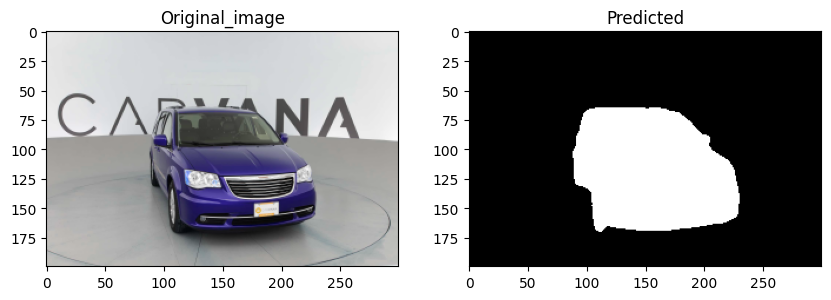

In [11]:
#model pre processing
image_cv2 = cv2.imread("data/val_images/fecea3036c59_16.jpg")
image_resize = imutils.resize(image_cv2,width=300)
pil_image  = Image.fromarray(image_resize)
img = T.ToTensor()(pil_image)
img  = img.unsqueeze(0)
#model predictions
preds = torch.sigmoid(model(img))
preds = (preds > 0.5).float()
#sequeez the image to 3d 
preds = preds.squeeze(0)
predict_numpy  = preds.numpy()
final_prediction= np.rollaxis(predict_numpy,0,3)

#displaying the image with predictions
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(image_resize)
plt.title("Original_image")
fig.add_subplot(1, 2, 2)
plt.imshow(final_prediction,cmap="gray")
plt.title("Predicted")
